Transforma pdf em imagem

In [1]:
from pdf2image import convert_from_path                                         # type: ignore

images = convert_from_path('./boardingpass_1.pdf')

In [2]:
import cv2
import numpy as np
from PIL import ImageEnhance, ImageOps, Image


# Função para aumentar o contraste e binarizar a imagem
def process_image(image):
    # Aumentar o contraste
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(5.0)  # Ajuste o valor para alterar o nível de contraste
    
    # Converter para escala de cinza
    gray_image = image.convert('L')
    
    # Binarizar a imagem (aplicar limiar)
    binarized_image = gray_image.point(lambda x: 0 if x < 128 else 255, '1')
    
    return binarized_image

    # # Converter a imagem para um formato compatível com o OpenCV
    # open_cv_image = np.array(binarized_image)
    # open_cv_image = open_cv_image.astype(np.uint8)

    # # Aplicar dilatação para aumentar a espessura do texto
    # kernel = np.ones((2, 2), np.uint8)  # Ajuste o tamanho do kernel para mais ou menos espessura
    # dilated_image = cv2.dilate(open_cv_image, kernel, iterations=1)
    
    # # Converter de volta para imagem PIL
    # final_image = Image.fromarray(dilated_image)
    
    # return final_image

# Aplicar processamento nas imagens
processed_images = [process_image(image) for image in images]

images = processed_images

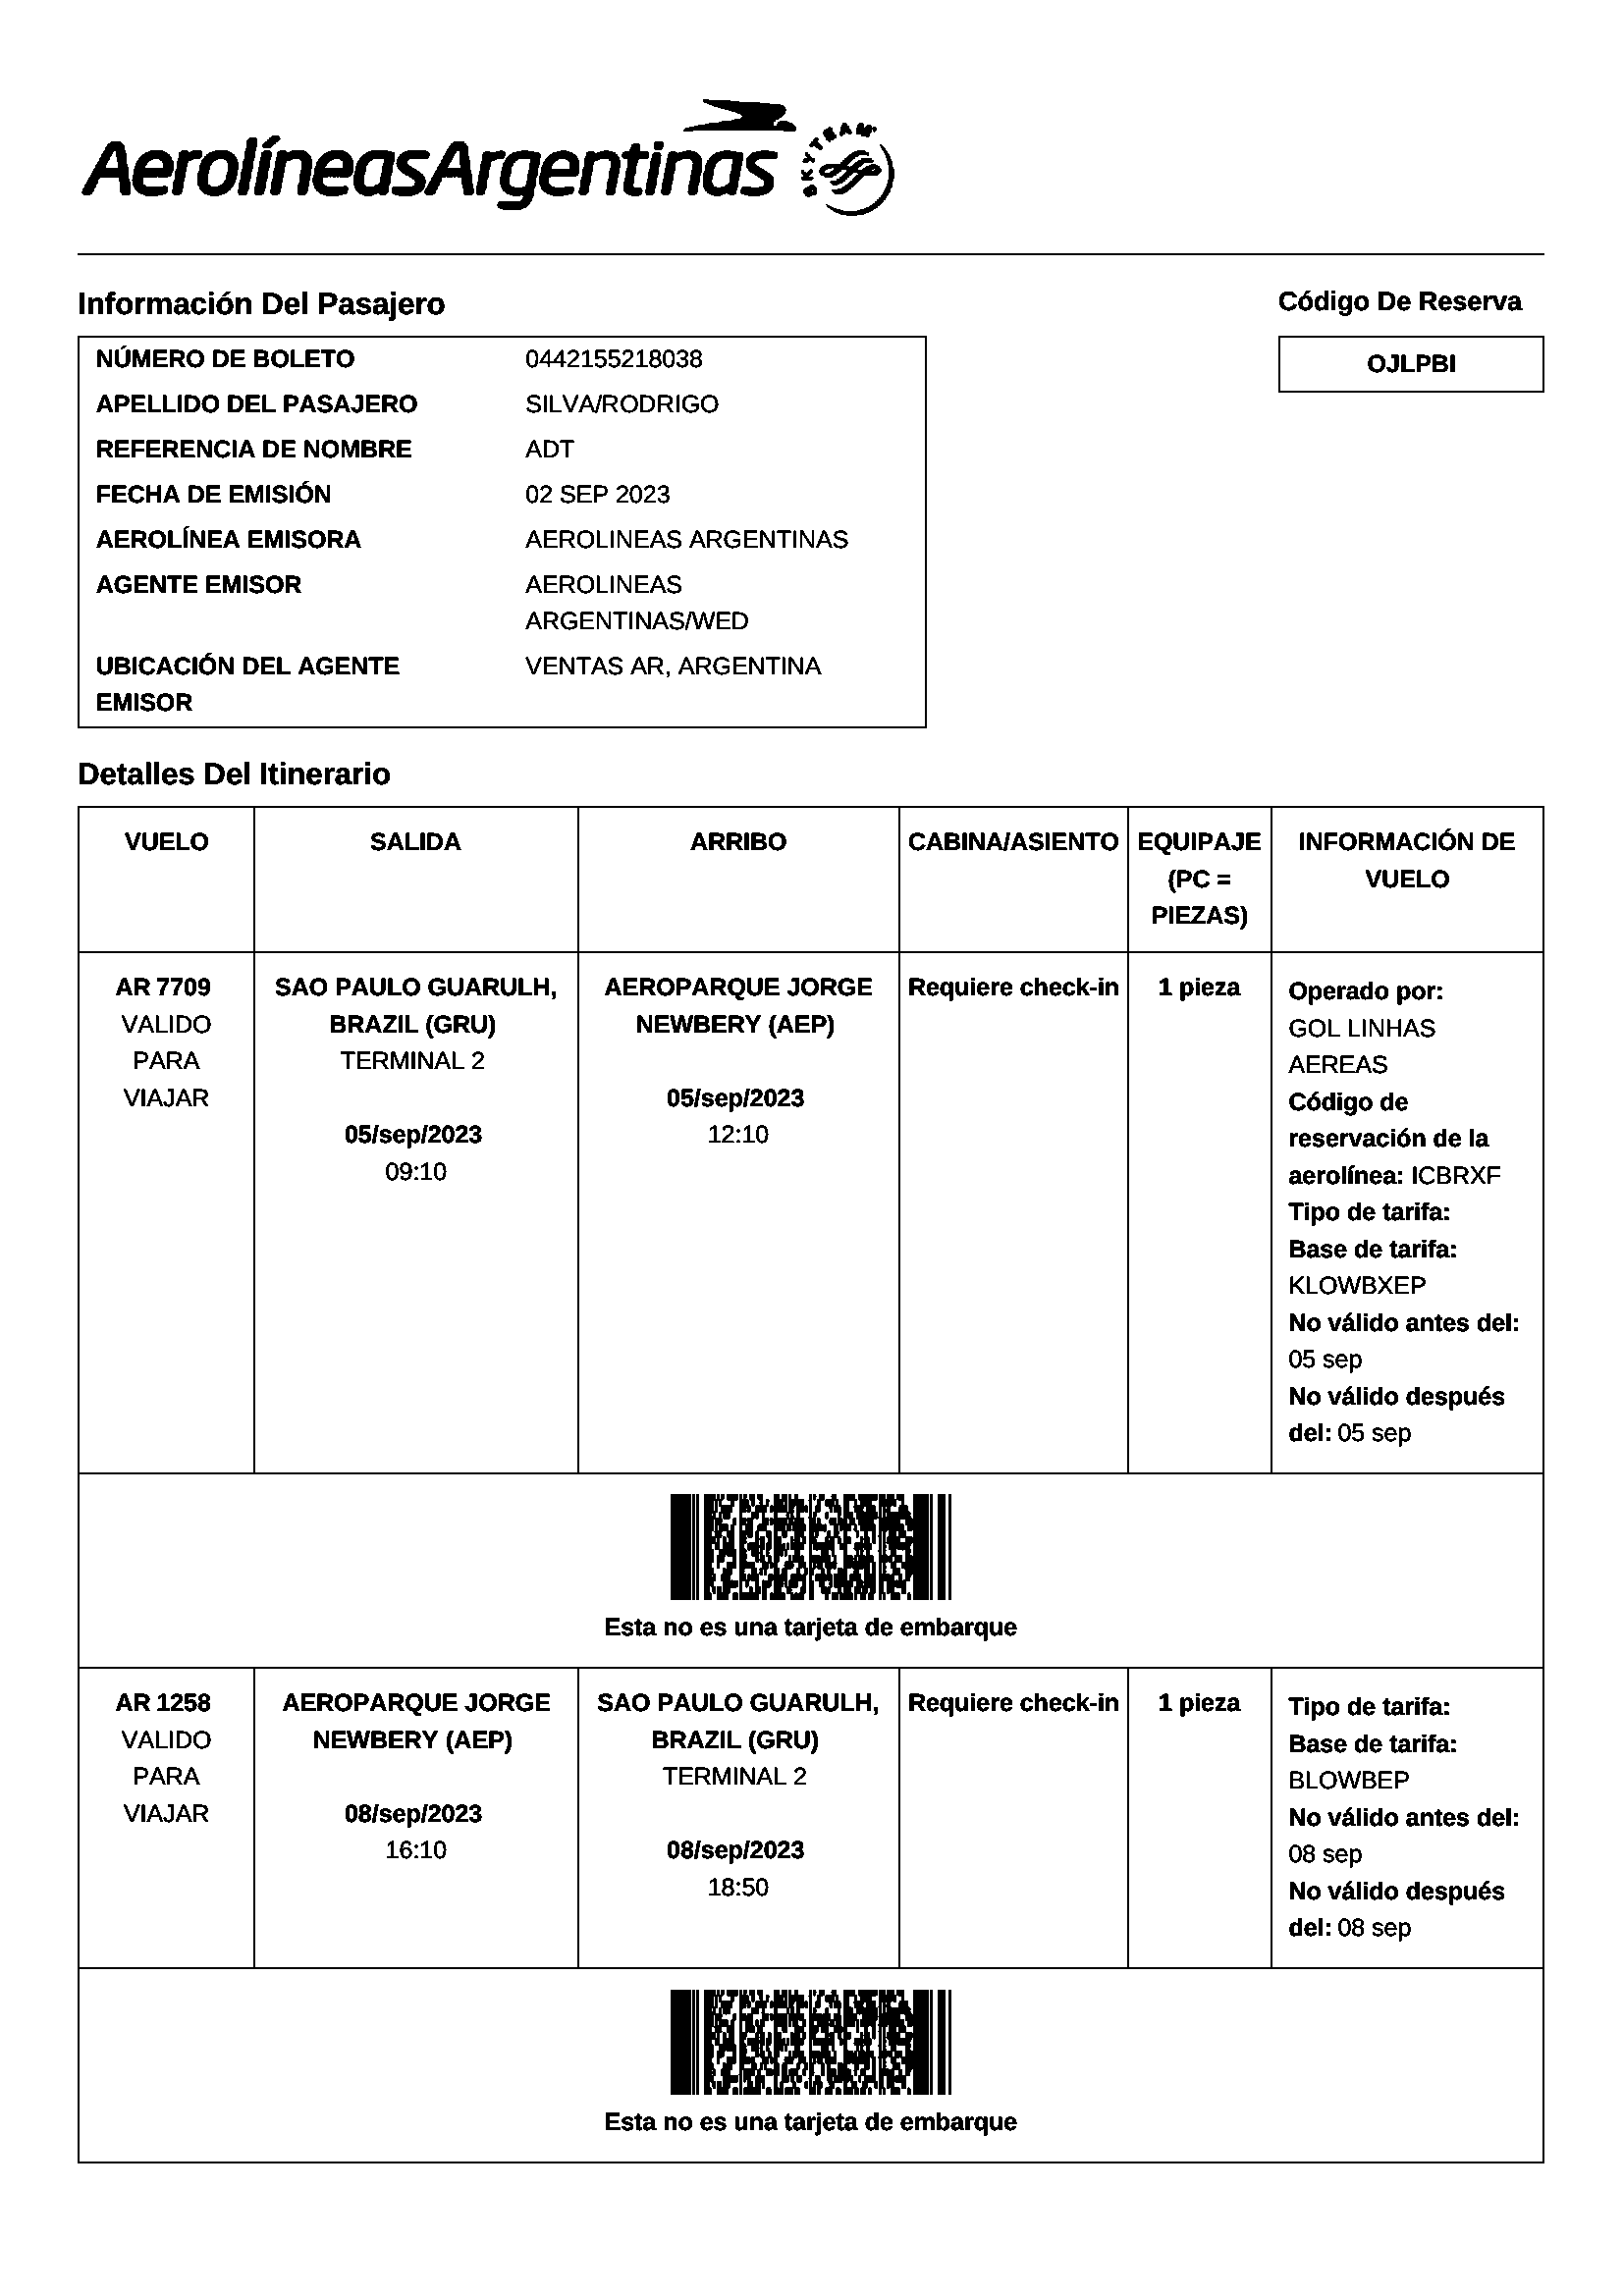

In [3]:
processed_images[0].show()

transforma imagem em string base64

In [4]:
import base64
from io import BytesIO

images_base64 = []
for image in images:
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
    images_base64.append(img_str)

Remove informações desnecessárias para a LLM da imagem em string base64

In [5]:
images_base64 = [
    str(file).replace('data:image/jpeg;base64,', '') 
    for file in images_base64
]

visualização da imagem em string base64

In [6]:
# from IPython.display import display, Image

# display( Image(data=base64.b64decode( images_base64[0] ), format='png') )

Executa processamento de extração de dados da imagem em string base 64

In [7]:
import sys
sys.path.insert(0, '../src/core/')

from llm import ILLM, Ollama, LLMBuilder                                        # type: ignore

vision_models = [ 'llava', 'phi3:instruct', 'bakllava', 'llava-llama3' ]

illm: ILLM = LLMBuilder( llm_type='ollama', model_name = vision_models[0], temperature=0 )
ollm: Ollama = illm.get_instance()

In [8]:
prompt = """
You are an assistant specialized in extracting structured data from images.

The images contain important information in table form, and your goal is to extract the following fields:

- "Nome/Name"
- "Bilhete/Ticket"

Output the extracted data in a structured JSON format.
If multiple tables are detected, create a separate JSON object for each table.

Images provided:
{{images}}

Respond only with the JSON representation of the table data.
"""

In [9]:
prompt = """
    USER:
        <image>
        Please read the text in this image and return the information in the 
        following JSON format(note xxx is placeholder, if the information is not
        avaiable in the image, put "N/A" instead).
        {
            "class": xxx,
            "DLN": xxx,
            "DOB": xxx,
            "Adress": xxx,
            "EXP": xxx,
            "ISS": xxx,
            "SEX": xxx,
            "HGT": xxx,
            "WGT": xxx,
            "EYES": xxx,
            "HAIR": xxx,
            "DONOR" xxx
        }
    ASSISTANT:
"""

In [10]:
from langchain_core.messages import HumanMessage, SystemMessage                 # type: ignore

In [11]:
system_message = SystemMessage(
    content="""
        You are an assistant specialized in extracting structured data from images based on the provided text, answer the following questions and respond exclusively with util data, without any additional comments or explanations.
        Images provided: {{images}}
    """
)
human_message=HumanMessage(
    content="""
        The images contain important information in boxes, and your goal is to extract the following fields:

        "Información Del Pasajero": {
            "NÚMERO DE BOLETO",
            "APELLIDO DEL PASAJERO",
            "REFERENCIA DE NOMBRE",
            "FECHA DE EMISIÓN",
            "AEROLÍNEA EMISORA",
            "AGENTE EMISOR",
            "UBICACIÓN DEL AGENTE EMISOR"
        }        
    """
)

In [12]:
response = ollm.bind(images= [ images_base64[0] ] ).invoke([system_message, human_message])
response

' {\n    "Información Del Pasajero": {\n        "NÚMERO DE BOLETO": "01",\n        "APELLIDO DEL PASAJERO": "SOLER",\n        "REFERENCIA DE NOMBRE": "001",\n        "FECHA DE EMISIÓN": "20/03/20",\n        "AEROLÍNEA EMISORA": "AERO LINES",\n        "AGENTE EMISOR": "SOLER",\n        "UBICACIÓN DEL AGENTE EMISOR": "SOLER"\n    }\n} '

In [13]:
# import cv2
# import json
# import base64
# import numpy as np

# # Decodifica a string base64 para um array de bytes
# image_data = base64.b64decode(images_base64[0])

# # Converte o array de bytes para um array numpy
# nparr = np.frombuffer(image_data, np.uint8)

# # Decodifica o array numpy para uma imagem usando o OpenCV
# image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

# # JSON com as coordenadas e dimensões das caixas
# boxes_json = '''
# [
#     { "x": 120, "y": 350, "width": 45, "height": 60},
#     { "x": 85,  "y": 210, "width": 70, "height": 30}
# ]
# '''

# # Carrega o JSON
# boxes = json.loads(boxes_json)

# # Verifica se a imagem foi carregada com sucesso
# if image is None:
#     print("Erro ao carregar a imagem.")
# else:
#     # Desenha cada caixa na imagem
#     for box in boxes:
#         x, y, w, h = box['x'], box['y'], box['width'], box['height']

#         # Converte as coordenadas e dimensões para inteiros
#         x, y, w, h = int(x), int(y), int(w), int(h)
        
#         # Desenha a caixa na imagem
#         cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

#     # Mostra a imagem com as caixas desenhadas
#     cv2.imshow('Imagem com Caixas', image)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
